# Interpolazione di Laplace o Interpolazione Armonica

L'interpolazione di Laplace o *harmonic interpolation* è un tipo di 
interpolazione che risolve l'equazione differenziale del tipo:
> $$\Delta u(x,y) \sim \frac{u(x - h, y) + u(x + h, y) + u(x, y - h) + u(x, y + h) - 4u(x,y)}{h^2}$$

In [1]:
# counter = 0 #Serve per salvare le diverse immagini

In [2]:
import numpy as np
from scipy.sparse import coo_matrix, linalg
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

def inpaint_nans(A, method=0):
    
    # Get the size of the array
    n, m = A.shape
    A = A.flatten()
    
    # Find NaN elements
    nan_indices = np.isnan(A) # k
    known_indices = ~nan_indices

    # Convert NaN indices to (r,c) form
    nan_list = np.array(np.where(nan_indices)).T # find(k)
    known_list = np.flatnonzero(known_indices) # find(\tilde k)
    
    nr, nc = np.unravel_index(nan_list, (n, m)) #order = 'F'
    nan_list = np.hstack((nan_list, nr, nc))
    
    # Default method
    
    if method not in [0, 1, 2, 3, 4, 5]:
        raise ValueError("Invalid method. Choose from 0 to 5.")

    if method == 0:

        # is it 1-d or 2-d?
        if m == 1 or n == 1:
            work_list = nan_list[:, 0]
            work_list = np.unique(np.concatenate([work_list, work_list - 1, work_list + 1]))
            work_list = work_list[(work_list > 0) & (work_list < n * m)]
            nw = len(work_list)

            u = np.arange(nw)
            fda = coo_matrix((np.tile([1, -2, 1], (nw, 1)), (np.repeat(u, 3), np.tile(work_list, 3))), shape=(nw, n * m))
        else:
            # a 2-d case
            # horizontal and vertical neighbors only
            talks_to = np.array([[-1, 0], [0, -1], [1, 0], [0, 1]])
            neighbors_list = identify_neighbors(n, m, nan_list, talks_to)

            # list of all nodes we have identified
            all_list = np.vstack((nan_list, neighbors_list))

            # generate sparse array with second partials on row variable
            # nodes between 0 and n-1
            L = np.where((all_list[:, 1] > 0) & (all_list[:, 1] < n - 1))[0]
            nl = len(L)
            
            if nl > 0:
                rows = np.tile(all_list[L, 0], (1,3)) #tre blocchi di L uno accanto all'altro 
                cols = rows + np.tile([-1, 0, 1], (1, nl))
                data = np.tile([1, -2, 1], (1, nl))
              
                fda = coo_matrix((data.ravel(), (rows.ravel(), cols.ravel())), shape=(n * m, n * m))
              
            else:
                fda = coo_matrix((n * m, n * m))

            # second partials on column index
            L = np.where((all_list[:, 2] > 0) & (all_list[:, 2] < m - 1))[0]
            nl = len(L)
            if nl > 0: 
                rows = np.tile(all_list[L, 0], (1,3)) #tre blocchi di L uno accanto all'altro
                cols = rows + np.tile([-1, 0, 1], (1, nl))
                data = np.tile([1, -2, 1], (1, nl))
                
                fda = fda + coo_matrix((data.ravel(), (rows.ravel(), cols.ravel())), shape=(n * m, n * m))
           
            rhs = -fda[:, known_list] * A[known_list]
            nan_indices = np.unique(fda[:, nan_list[:, 0]].nonzero()[0])
            B = A.copy()
            B[nan_list[:, 0]] = lsqr(fda[nan_indices, :][:, nan_list[:, 0]], rhs[nan_indices], atol=1e-07, btol=1e-07,)[0] 

    return B.reshape(n, m)

In [3]:
def identify_neighbors(n, m, nan_list, talks_to):
    """
    identify_neighbors: identifies all the neighbors of
    those nodes in nan_list, not including the nans
    themselves
    """
    if len(nan_list) != 0:
        # use the definition of a neighbor in talks_to
        nan_count = nan_list.shape[0]
        talk_count = talks_to.shape[0]

        nn = np.zeros((nan_count * talk_count, 2))
        j = [0, nan_count]
        
        for i in range(talk_count):
            nn[j[0]:j[1], :] = nan_list[:, 1:2] + np.tile(talks_to[i,:], (nan_count, 1))
            j = [j[0] + nan_count, j[1] + nan_count]

        # drop those nodes which fall outside the bounds of the
        # original array
        L = (nn[:, 0] < 0) | (nn[:, 0] > n) | (nn[:, 1] < 0) | (nn[:, 1] > m)
        newL = ~L
        newL = newL.astype(int)
        nn = nn[newL,:] 
        nn = nn.astype(int)
        
        # form the same format 3 column array as nan_list
        neighbors_list = np.column_stack((np.ravel_multi_index((nn[:, 0]+1, nn[:, 1]+1), (n, m)), nn))

        # delete replicates in the neighbors list
        neighbors_list = np.unique(neighbors_list, axis=0)
        
        # and delete those which are also in the list of NaNs.
        neighbors_list = neighbors_list[~np.isin(neighbors_list, nan_list).all(axis=1)]      

    else:
        neighbors_list = np.array([], dtype=int)

    return neighbors_list

## Demosaicizzazione lineare

Implementazione della demosaicizzazione tramite interpolazione lineare: per ogni pixel si effettua 
una media dei valori dei pixel vicini.

Il pattern utilizzato per questo algoritmo è il Pattern di Bayer RGGB.

In [5]:
def combine_channels(ch1, ch2, ch3):
    return np.dstack((ch1, ch2, ch3))

def demosaic_simple_naive_rgb(img):
    
    s = img.shape
    img = img.astype(np.uint16)
    red = np.zeros_like(img)
    blue = np.zeros_like(img)
    green = np.zeros_like(img)

    for i in range(s[0]): # rows
        for j in range(s[1]): # columns
            im1, ip1, jm1, jp1 = (max(0, i - 1), min(i + 1, s[0] - 1), max(0, j - 1), min(j + 1, s[1] - 1)) # per i pixel al bordo
            if (i % 2 == 0 and j % 2 == 0): # canale del rosso
                
                red[i, j] = img[i, j]
                blue[i, j] = (img[im1, jm1] + img[ip1, jm1] + img[ip1, jp1] + img[im1, jp1]) // 4 # media dei valori dei punti vicini
                green[i, j] = (img[im1, j] + img[ip1, j] + img[i, jm1] + img[i, jp1]) // 4
                
            elif (i % 2 == 1 and j % 2 == 1): # canale del blu
                
                blue[i, j] = img[i, j]
                red[i, j] = (img[im1, jm1] + img[ip1, jm1] + img[ip1, jp1] + img[im1, jp1]) // 4
                green[i, j] = (img[im1, j] + img[ip1, j] + img[i, jm1] + img[i, jp1]) // 4
                
            else: # canale del verde
                green[i, j] = img[i, j]
                if (i % 2 == 0): 
                    
                    red[i, j] = (img[i, jm1] + img[i, jp1]) // 2
                    blue[i, j] = (img[im1, j] + img[ip1, j]) // 2
                    
                else:
                    
                    blue[i, j] = (img[i, jm1] + img[i, jp1]) // 2
                    red[i, j] = (img[im1, j] + img[ip1, j]) // 2

    return (red, green, blue)

def demosaic_simple_naive(img):
    
    red,green,blue = demosaic_simple_naive_rgb(img)
    return combine_channels(red,green,blue).astype(np.uint8)

<built-in function seed>
Tempo impiegato per l'Inpaint in secondi: 52.382080999999744
Tempo impiegato per la Demosaicizzazione Semplice in secondi: 8.819174799999018


C:/Users/Psi/AppData/Local/Temp/xpython_22456/754403433.py:69: RuntimeWarning: invalid value encountered in cast
  ax[1].imshow(Gnan.astype(np.uint8))


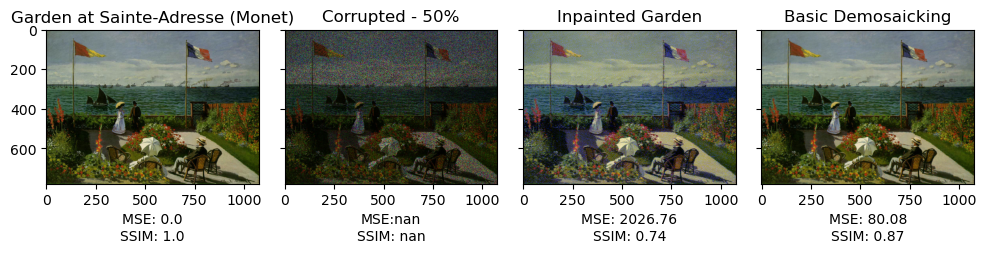

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image

from skimage import data, img_as_float, io, color
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

garden = np.array(Image.open('images/monet_adresse.jpg')) # Legge l'immagine
G = garden.astype(float) 
G[np.random.rand(*G.shape) < 0.50] = np.nan # Rende NaN il 50% dell'immagine

tic = time.perf_counter()

Gnan = G.copy()
Gdemosaic = G.copy()

G[:, :, 0] = inpaint_nans(G[:, :, 0], 0)
G[:, :, 1] = inpaint_nans(G[:, :, 1], 0)
G[:, :, 2] = inpaint_nans(G[:, :, 2], 0)

toc_inpaint = time.perf_counter()

print('Tempo impiegato per l\'Inpaint in secondi:', toc_inpaint-tic)

Red = garden[:,:,0]
Green = garden[:,:,1]
Blue = garden[:,:,2]

bayer = np.empty((garden[:,:,0].shape), np.uint8)

bayer[0::2, 0::2] = Red[0::2, 0::2]   # top left 
bayer[0::2, 1::2] = Green[0::2, 1::2] # top right
bayer[1::2, 0::2] = Green[1::2, 0::2] # bottom left
bayer[1::2, 1::2] = Blue[1::2, 1::2]  # bottom right

Gdemosaic = demosaic_simple_naive(bayer) # RGGB Pattern

toc_demosaic = time.perf_counter()

print('Tempo impiegato per la Demosaicizzazione Semplice in secondi:', toc_demosaic-toc_inpaint)

# Structural Similarity Index

mse_original = mean_squared_error(garden, garden)
ssim_original = ssim(garden, garden, data_range = garden.max() - garden.min(), channel_axis=2)

mse_nan = mean_squared_error(garden, Gnan)
ssim_nan = ssim(garden, Gnan, data_range = Gnan.max() - Gnan.min(), channel_axis=2)

mse_inpaint = mean_squared_error(garden, G)
ssim_inpaint = ssim(garden, G, data_range = G.max() - G.min(), channel_axis=2)

mse_demosaic = mean_squared_error(garden, Gdemosaic)
ssim_demosaic = ssim(garden, Gdemosaic, data_range = Gdemosaic.max() - Gdemosaic.min(), channel_axis=2)

# PLotting

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(garden.astype(np.uint8))
ax[0].set_xlabel('MSE: ' + str(round(mse_original, 2)) + '\n' + 'SSIM: ' + str(round(ssim_original, 2)))
ax[0].set_title('Garden at Sainte-Adresse (Monet)')

ax[1].imshow(Gnan.astype(np.uint8))
ax[1].set_xlabel('MSE:' + str(round(mse_nan, 2)) + '\n' + 'SSIM: ' + str(round(ssim_nan, 2)))
ax[1].set_title('Corrupted - 50%')

ax[2].imshow(G.astype(np.uint8))
ax[2].set_xlabel('MSE: ' + str(round(mse_inpaint, 2)) + '\n' + 'SSIM: ' + str(round(ssim_inpaint, 2)))
ax[2].set_title('Inpainted Garden')

ax[3].imshow(Gdemosaic.astype(np.uint8))
ax[3].set_xlabel('MSE: ' + str(round(mse_demosaic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_demosaic, 2)))
ax[3].set_title('Basic Demosaicking')

# plt.savefig('images/inpaint_result' + str(counter) + '.png')
# counter = counter + 1

plt.tight_layout()
plt.show()

# Rescaling e applicazione del pattern di Bayer

Dimensioni dell'immagine originale (778, 1075, 3)
Dimensioni dell'immagine con np.resize (778, 1074, 3)
Dimensioni dell'immagine con rescale (770, 1064, 3)
Dimensioni dell'immagine con resize (770, 1064, 3)
Dimensioni dell'immagine con downscale_local_mean (778, 1075, 3)


Text(0.5, 1.0, 'downscale_local_mean')

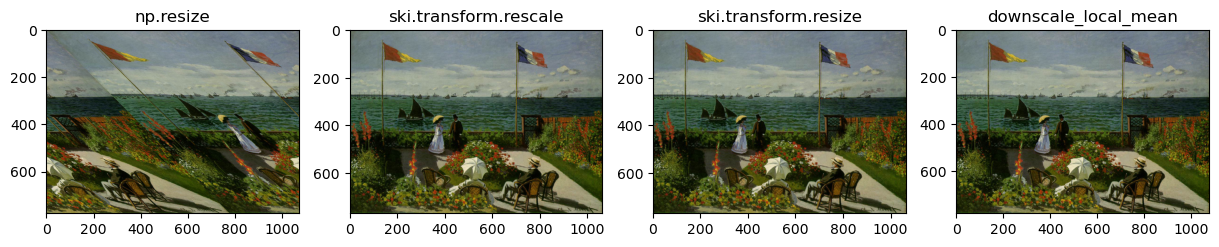

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image

garden = np.array(Image.open('images/monet_adresse.jpg')) # Legge l'immagine
m,n = garden[:,:,0].shape

print('Dimensioni dell\'immagine originale', garden.shape)

resized_garden_numpy = np.resize(garden, [m, n-1, 3]) # Non una buona rappresentazione del resize
print('Dimensioni dell\'immagine con np.resize', resized_garden_numpy.shape)

resized_garden_rescale = ski.transform.rescale(garden, 0.99, anti_aliasing = False, channel_axis=2) # Rescale
resized_garden_rescale = ski.util.img_as_ubyte(resized_garden_rescale)
print('Dimensioni dell\'immagine con rescale', resized_garden_rescale.shape)

resized_garden_resize = ski.transform.resize(garden, (garden.shape[0] // 1.01, garden.shape[1] // 1.01)) # Resize
resized_garden_resize = ski.util.img_as_ubyte(resized_garden_resize)
print('Dimensioni dell\'immagine con resize', resized_garden_resize.shape)

resized_garden_downscale = ski.transform.downscale_local_mean(garden, (1, 1, 1)) # Downscale - modifica l'aspect ratio
print('Dimensioni dell\'immagine con downscale_local_mean', resized_garden_downscale.shape)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
ax = axes.ravel()

ax[0].imshow(resized_garden_numpy.astype(np.uint8))
ax[0].set_title('np.resize')

ax[1].imshow(resized_garden_rescale.astype(np.uint8))
ax[1].set_title('ski.transform.rescale')

ax[2].imshow(resized_garden_resize.astype(np.uint8))
ax[2].set_title('ski.transform.resize')

ax[3].imshow(resized_garden_downscale.astype(np.uint8))
ax[3].set_title('downscale_local_mean')


 CANALE DEL ROSSO: 

[[ nan  nan  nan ...  nan  nan  nan]
 [111.  nan 105. ...  nan 108.  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 ...
 [ 58.  nan  33. ...  nan 157.  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 [ 60.  nan  50. ...  nan 149.  nan]]

 CANALE DEL VERDE: 

[[122.  nan 116. ...  nan 110.  nan]
 [ nan 119.  nan ... 113.  nan 111.]
 [122.  nan 115. ...  nan 119.  nan]
 ...
 [ nan  72.  nan ... 126.  nan 129.]
 [ 82.  nan  69. ...  nan 131.  nan]
 [ nan  79.  nan ... 139.  nan 136.]]

 CANALE DEL BLU: 

[[ nan 102.  nan ... 121.  nan 112.]
 [ nan  nan  nan ...  nan  nan  nan]
 [ nan 102.  nan ... 112.  nan 119.]
 ...
 [ nan  nan  nan ...  nan  nan  nan]
 [ nan  12.  nan ...  91.  nan  85.]
 [ nan  nan  nan ...  nan  nan  nan]]




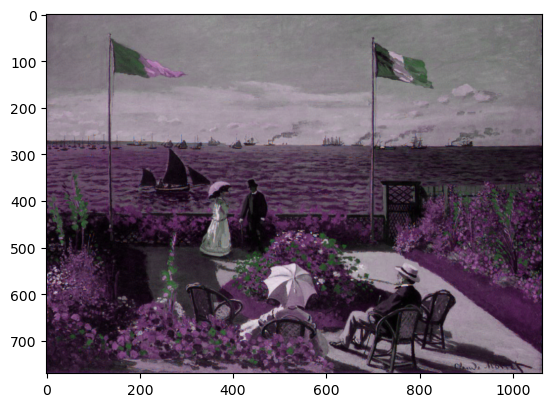

In [10]:
# Bayer Pattern GBRG - Rescale

m,n = resized_garden_rescale[:,:,0].shape # Considero le nuove dimensioni

Red_Inpaint = np.nan *np.ones(resized_garden_rescale[:,:,0].shape)
Red_Inpaint[1:m:2, 0:n-1:2] = resized_garden_rescale[1:m:2, 0:n-1:2, 0]

Green_Inpaint = np.nan *np.ones(resized_garden_rescale[:,:,1].shape)
Green_Inpaint[0:m-1:2, 0:n-1:2] = resized_garden_rescale[0:m-1:2, 0:n-1:2, 1]
Green_Inpaint[1:m:2, 1:n:2] = resized_garden_rescale[1:m:2, 1:n:2, 1]

Blue_Inpaint = np.nan *np.ones(resized_garden_rescale[:,:,2].shape)
Blue_Inpaint[0:m:2, 1:n:2] = resized_garden_rescale[0:m:2, 1:n:2, 2]

print('\n CANALE DEL ROSSO: \n')
print(Red_Inpaint)
print('\n CANALE DEL VERDE: \n')
print(Green_Inpaint)
print('\n CANALE DEL BLU: \n')
print(Blue_Inpaint)
print('\n')


# Demosaicizzazione con Pattern GBRG

bayer = np.empty((m, n), np.uint8)
# strided slicing for this pattern: 
# G B
# R G 
bayer[0::2, 0::2] = Green_Inpaint[0::2, 0::2] # top left 
bayer[0::2, 1::2] = Blue_Inpaint[0::2, 1::2]  # top right
bayer[1::2, 0::2] = Red_Inpaint[1::2, 0::2]   # bottom left
bayer[1::2, 1::2] = Green_Inpaint[1::2, 1::2] # bottom right

Gdemosaic = demosaic_simple_naive(bayer) # L'algoritmo si basa sul pattern RGGB?

plt.imshow(Gdemosaic.astype(np.uint8))

In [13]:
# Bayer Pattern RGGB - Rescale

m,n = resized_garden_rescale[:,:,0].shape # Considero le nuove dimensioni

Red_Inpaint = np.nan *np.ones(resized_garden_rescale[:,:,0].shape)
Red_Inpaint[0:m-1:2, 0:n-1:2] = resized_garden_rescale[0:m-1:2, 0:n-1:2, 0]

Green_Inpaint = np.nan *np.ones(resized_garden_rescale[:,:,1].shape)
Green_Inpaint[0:m:2, 1:n:2] = resized_garden_rescale[0:m:2, 1:n:2, 1]
Green_Inpaint[1:m:2, 0:n-1:2] = resized_garden_rescale[1:m:2, 0:n-1:2, 1]

Blue_Inpaint = np.nan *np.ones(resized_garden_rescale[:,:,2].shape)
Blue_Inpaint[1:m:2, 1:n:2] = resized_garden_rescale[1:m:2, 1:n:2, 2]

print('\n CANALE DEL ROSSO: \n')
print(Red_Inpaint)
print('\n CANALE DEL VERDE: \n')
print(Green_Inpaint)
print('\n CANALE DEL BLU: \n')
print(Blue_Inpaint)
print('\n')


 CANALE DEL ROSSO: 

[[111.  nan 105. ...  nan 111.  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 [111.  nan 104. ...  nan 120.  nan]
 ...
 [ nan  nan  nan ...  nan  nan  nan]
 [ 51.  nan  39. ...  nan 143.  nan]
 [ nan  nan  nan ...  nan  nan  nan]]

 CANALE DEL VERDE: 

[[ nan 119.  nan ... 123.  nan 114.]
 [122.  nan 116. ...  nan 107.  nan]
 [ nan 119.  nan ... 117.  nan 124.]
 ...
 [ 86.  nan  59. ...  nan 144.  nan]
 [ nan  66.  nan ... 133.  nan 130.]
 [ 94.  nan  83. ...  nan 138.  nan]]

 CANALE DEL BLU: 

[[ nan  nan  nan ...  nan  nan  nan]
 [ nan 102.  nan ... 109.  nan 107.]
 [ nan  nan  nan ...  nan  nan  nan]
 ...
 [ nan  21.  nan ...  87.  nan  85.]
 [ nan  nan  nan ...  nan  nan  nan]
 [ nan  22.  nan ...  96.  nan  90.]]




Text(0.5, 1.0, 'Demosaicking')

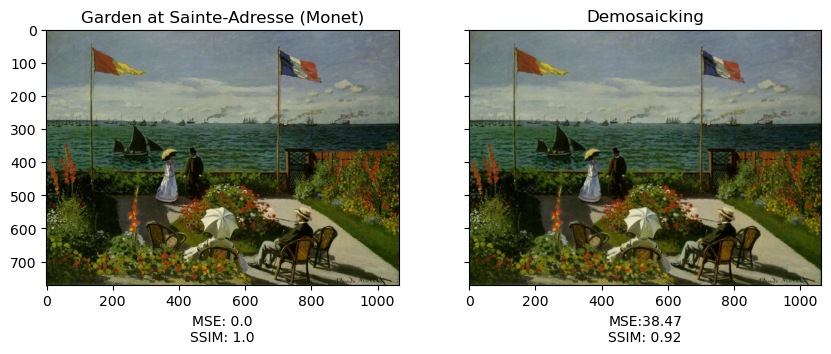

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Demosaicizzazione con Pattern GBRG

bayer = np.empty((m, n), np.uint8)

bayer[0::2, 0::2] = Red_Inpaint[0::2, 0::2]   # top left 
bayer[0::2, 1::2] = Green_Inpaint[0::2, 1::2] # top right
bayer[1::2, 0::2] = Green_Inpaint[1::2, 0::2] # bottom left
bayer[1::2, 1::2] = Blue_Inpaint[1::2, 1::2]  # bottom right

Gdemosaic = demosaic_simple_naive(bayer) 

mse_original = mean_squared_error(resized_garden_rescale, resized_garden_rescale)
ssim_original = ssim(resized_garden_rescale, resized_garden_rescale,
                     data_range = resized_garden_rescale.max() - resized_garden_rescale.min(), channel_axis=2)

mse_demosaic = mean_squared_error(resized_garden_rescale, Gdemosaic)
ssim_demosaic = ssim(resized_garden_rescale, Gdemosaic, data_range = Gdemosaic.max() - Gdemosaic.min(), channel_axis=2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(resized_garden_rescale.astype(np.uint8))
ax[0].set_xlabel('MSE: ' + str(round(mse_original, 2)) + '\n' + 'SSIM: ' + str(round(ssim_original, 2)))
ax[0].set_title('Garden at Sainte-Adresse (Monet)')

ax[1].imshow(Gdemosaic.astype(np.uint8))
ax[1].set_xlabel('MSE:' + str(round(mse_demosaic, 2)) + '\n' + 'SSIM: ' + str(round(ssim_demosaic, 2)))
ax[1].set_title('Demosaicking')

# Costruzione della SVD troncata

Rango della matrice di partenza: 778
Approssimazione SVD compatta: (778, 1075)
Errore relativo pari a: 1.0397595889479518e-14
Approssimazione SVD Troncata alla 100 iterazione: (778, 1075)
Errore relativo pari a: 0.009937014928690991


Text(0.5, 1.0, 'SVD Troncata al 100 valore')

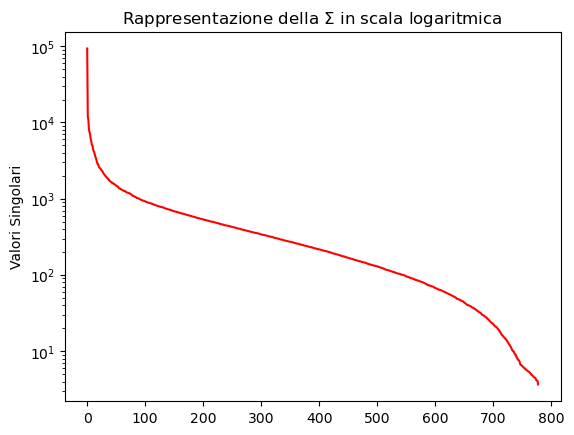

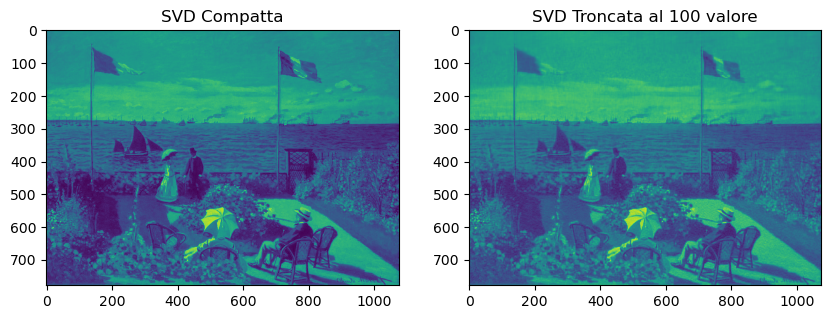

In [9]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from PIL import Image

garden = np.array(Image.open('images/monet_adresse.jpg'))
svd_garden = garden[:,:,1]

U, S, V = linalg.svd(svd_garden)
plt.semilogy(S, '-r')
plt.ylabel('Valori Singolari')
plt.title('Scree Plot della $\Sigma$ in scala logaritmica')

# SVD Compatta
r = linalg.matrix_rank(svd_garden)
print('Rango della matrice di partenza:', r)

A_rank = U[:, 0:r] @ np.diag(S) @ V[0:r, :]

print('Approssimazione SVD compatta:', A_rank.shape)

print('Errore relativo pari a:', linalg.norm(svd_garden - A_rank, 2)/linalg.norm(svd_garden, 2))

# SVD Troncata
k = 1
A_k = U[:, 0:k] @ np.diag(S[0:k]) @ V[0:k, :]
# tol = 1e-6 # Tolleranza troppo stretta
tol = 1e-2

while(linalg.norm(svd_garden - A_k, 2)/linalg.norm(svd_garden, 2) > tol and k != r):
    A_k = U[:, 0:k] @ np.diag(S[0:k]) @ V[0:k, :]
    k += 1
    
print('Approssimazione SVD Troncata alla', k, 'iterazione:', A_k.shape)
    
print('Errore relativo pari a:', linalg.norm(svd_garden - A_k, 2)/linalg.norm(svd_garden, 2))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(A_rank)
ax[0].set_title('SVD Compatta')

ax[1].imshow(A_k)
ax[1].set_title('SVD Troncata al ' + str(k) + ' valore')
